# Trying to fix the 47 Tuc orbital pulsars fitting that broke somehow

At some point in the past month the orbital (binary) pulsar likelihoods seem to have broken, and are always failing (i.e. returning -inf).
This notebook is to try and figure out why.

In [1]:
from fitter.probabilities.pulsars import *
import fitter
import numpy
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import scipy.interpolate as interp

%matplotlib inline
%config InlineBackend.figure_format = "retina"


In [2]:
import seaborn

seaborn.set(context="notebook", style="darkgrid")
plt.rcParams["figure.figsize"] = (8, 6)

In [3]:
obs = fitter.Observations('47_Tuc')
# theta = obs.initials.values()
theta = [6.1, 1.06, 8.1, 1.23, 0.7, 0.45, 0.1, 0.45, 0.5, 1.3, 2.5, 0.5, 4.45]
# theta = [6.347, 0.967, 7.468, 1.282, 0.841, 0.454, 0.006, 0.268, 0.589, 0.553, 2.589, 0.204, 4.439]

model = fitter.Model(theta, obs)

u.set_enabled_equivalencies(fitter.util.angular_width(model.d))
*_, μ, crd = obs.valid_likelihoods[-3]

/home/peter/research/GCfit/fitter/probabilities/pulsars.py:286: RuntimeWarning: invalid value encountered in log10
  Pdot_int = np.log10(Pdot_int)


In [4]:
def likelihood_pulsar_orbital(model, pulsars, cluster_μ, coords, *, mass_bin=None):
    
    # ----------------------------------------------------------------------
    # Get pulsar mass bins
    # ----------------------------------------------------------------------

    if mass_bin is None:
        if 'm' in pulsars.mdata:
            mass_bin = np.where(model.mj == pulsars.mdata['m'] * u.Msun)[0][0]
        else:
            logging.debug("No mass bin provided for pulsars, using -1")
            mass_bin = -1

    # ----------------------------------------------------------------------
    # Iterate over all pulsars
    # ----------------------------------------------------------------------

    N = pulsars['r'].size
    probs = np.zeros(N)

    fig, axarr = plt.subplots(N, 3, figsize=(17, 35))

    for i in range(N):

        axrow = axarr[i]

        # ------------------------------------------------------------------
        # Get this pulsars necessary data
        # ------------------------------------------------------------------

        id_ = pulsars['id'][i].value.decode()
        axrow[0].set_title(f'Pulsar "{id_}"')

        print(i, id_)
        
        R = pulsars['r'][i].to(u.pc)

        Pb = pulsars['Pb'][i].to('s')

        Pbdot_meas = pulsars['Pbdot_meas'][i]
        ΔPbdot_meas = pulsars['ΔPbdot_meas'][i]
        
        axrow[1].set_title(f'$\dot{{P_b}}=${Pbdot_meas.value} ($\pm$ {ΔPbdot_meas.value})')

        # ------------------------------------------------------------------
        # Compute the cluster component distribution, from the model
        # ------------------------------------------------------------------

        PdotP_domain, PdotP_c_prob = cluster_component(model, R, mass_bin)
        Pdot_domain = (Pb * PdotP_domain).decompose()

        axrow[0].plot(Pdot_domain, PdotP_c_prob, 'r-')

        # linear to avoid effects around asymptote
        Pdot_c_spl = interp.UnivariateSpline(
            Pdot_domain, PdotP_c_prob, k=1, s=0, ext=1
        )

        # ------------------------------------------------------------------
        # Compute gaussian measurement error distribution
        # ------------------------------------------------------------------

        err = fitter.util.gaussian(x=Pdot_domain, sigma=ΔPbdot_meas, mu=0)

        err_spl = interp.UnivariateSpline(Pdot_domain, err, k=1, s=0, ext=1)

        axrow[1].plot(Pdot_domain, err, 'g-')

        # ------------------------------------------------------------------
        # Set up the equally-spaced linear convolution domain
        # ------------------------------------------------------------------

        # mirrored/starting at zero so very small gaussians become the δ-func
        lin_domain = np.linspace(0., 1e-11, 5_000 // 2)
        lin_domain = np.concatenate((np.flip(-lin_domain[1:]), lin_domain))

        axrow[0].plot(lin_domain, Pdot_c_spl(lin_domain), 'r--')
        axrow[1].plot(lin_domain, err_spl(lin_domain), 'g--')
        
        # Testing the err without this small domain
        err2 = fitter.util.gaussian(x=lin_domain, sigma=ΔPbdot_meas, mu=0)

        axrow[1].plot(lin_domain, err2, 'm-.')

        
        # ------------------------------------------------------------------
        # Convolve the different distributions
        # ------------------------------------------------------------------

        # conv = np.convolve(err, PdotP_c_prob, 'same')
        conv = np.convolve(err_spl(lin_domain), Pdot_c_spl(lin_domain), 'same')

        # Normalize
        conv /= interp.UnivariateSpline(
            lin_domain, conv, k=1, s=0, ext=1
        ).integral(-np.inf, np.inf)
        
        conv2 = np.convolve(err2, Pdot_c_spl(lin_domain), 'same')

        # Normalize
        conv2 /= interp.UnivariateSpline(
            lin_domain, conv2, k=1, s=0, ext=1
        ).integral(-np.inf, np.inf)

        # ------------------------------------------------------------------
        # Compute the Shklovskii (proper motion) effect component
        # ------------------------------------------------------------------

        cluster_μ <<= u.Unit("mas/yr")

        PdotP_pm = shklovskii_component(cluster_μ, model.d)

        # ------------------------------------------------------------------
        # Compute the galactic potential component
        # ------------------------------------------------------------------

        PdotP_gal = galactic_component(*(coords * u.deg), D=model.d)

        # ------------------------------------------------------------------
        # Interpolate the likelihood value from the overall distribution
        # ------------------------------------------------------------------

        prob_dist = interp.interp1d(
            (lin_domain / Pb) + PdotP_pm + PdotP_gal, conv,
            assume_sorted=True, bounds_error=False, fill_value=0.0
        )

        probs[i] = prob_dist(Pbdot_meas / Pb)
        
        print(probs[i])
        print()
        
        axrow[2].plot((lin_domain / Pb) + PdotP_pm + PdotP_gal, conv, 'b-')
        axrow[2].plot((lin_domain / Pb) + PdotP_pm + PdotP_gal, conv2, 'm--')
        axrow[2].axvline((Pbdot_meas / Pb).value, color="orange")

    # ----------------------------------------------------------------------
    # Multiply all the probabilities and return the total log probability.
    # ----------------------------------------------------------------------

    fig.tight_layout()
    
    return np.sum(np.log(probs))


0 J0024-7204E
50194192702.84268

1 J0024-7204H


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


96398418900.22588

2 J0024-7204I
364763963575.0972

3 J0024-7204Q


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


280454528062.02856

4 J0024-7204R


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


2168078039639.3906

5 J0024-7204S
6981972982.6273

6 J0024-7204T


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


125306195130.27852

7 J0024-7204U
357238954714.34106

8 J0024-7204X
25257450185.800735

9 J0024-7204Y


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


288494498090.4582



256.48059986018876

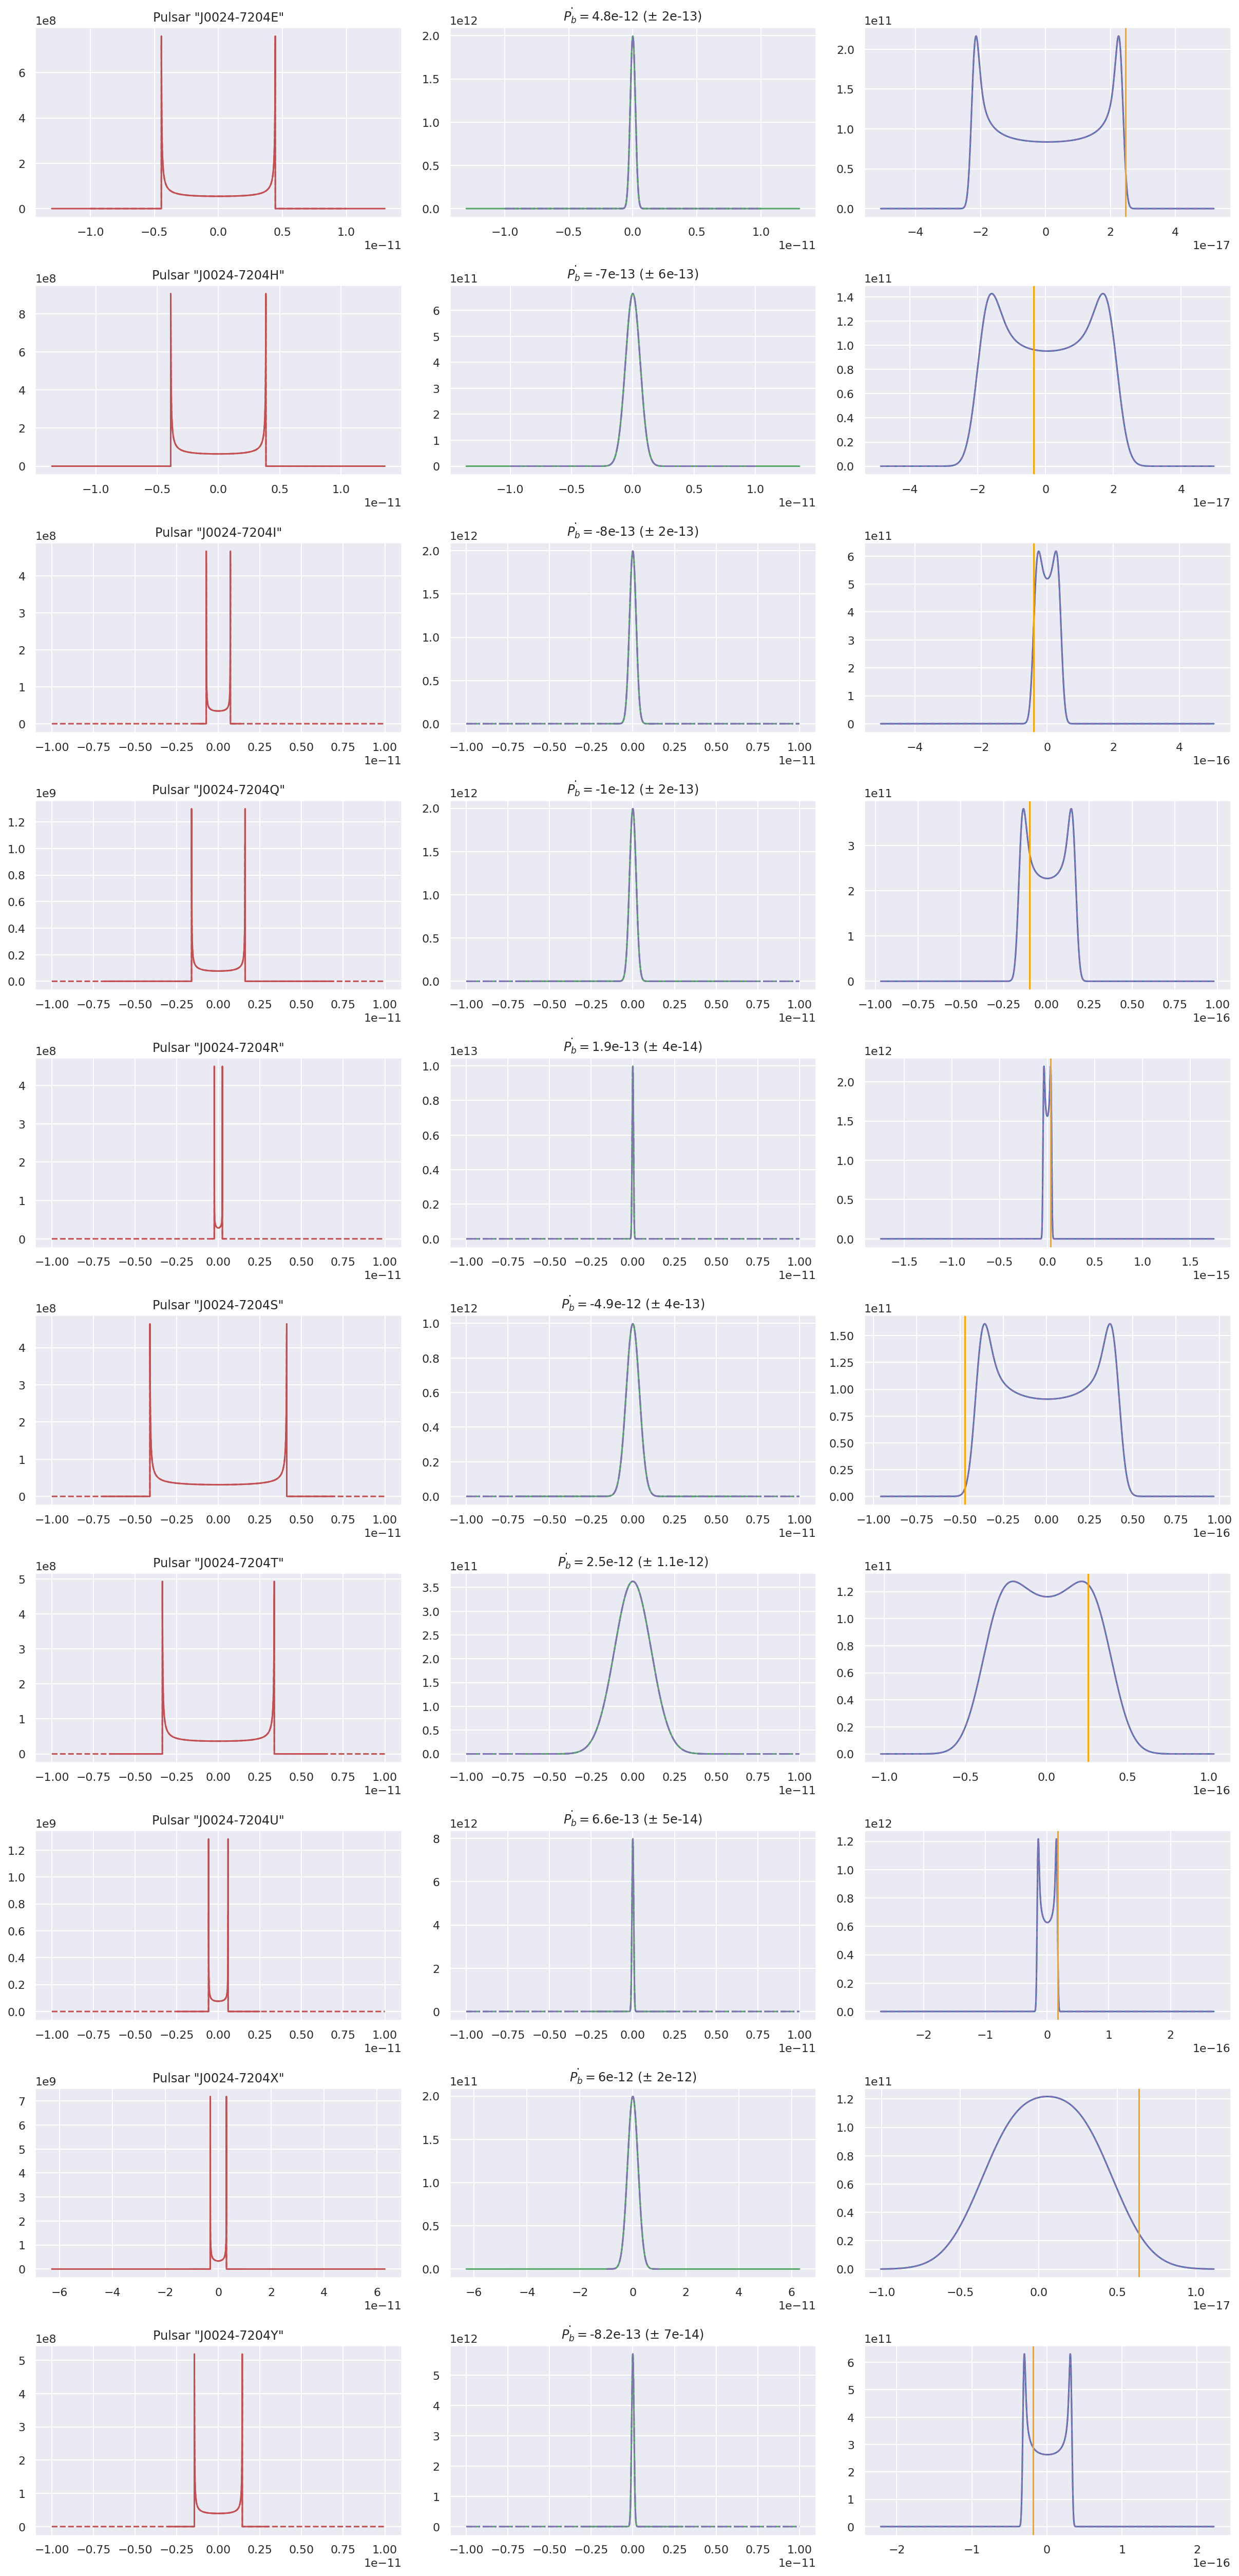

In [5]:
likelihood_pulsar_orbital(model, obs['pulsar/orbital'], μ, crd)

In [6]:
plt.close('all')

So a couple things, it looks like. Firstly, the fix I came up with before to requiring the orbital likelihood to use the lin_domain, just like the spin likelihood, seems like the right
choice, the new cuts on the cluster_component (and the lack of zeroed tails after it) was justified by me claiming it would always be used in a spline with constant 0 outside the boundaries. This wasn't the case before in the orbital, cause I guess I forgot about that, so that was a needed fix. Of course this means the lin_domain has to be set up correctly as
well, you can't just copy from spin cause the order of magnitudes are way different. That was also a mistake.

-> I'm wondering if it might be smart to start enforcing this, a la returning a spline instead of the domain and probability?

Secondly, this Pdot_domain was being used to create the gaussian error curves. This was a problem, considering the new cutoff, cause the full gaussian tails weren't present, or allowed
to go to zero, and so the splines, with explicitly zeroed boundaries, were creating weird cutoff gaussians, which was what was leading to the strange triangle final convolution curves.
I think this may also still be an issue in the spin likelihoods, although I don't know how much problems it's causing considering it's only really noticeable when the gaussian curve is
large compared to the others, and in the spin it's always dominated by either the cluster or the intrinsic (I believe)

I'm not super happy with how this has evolved to now pretty much requiring a dense, arbitrary lin_domain for every part. It feels like this is going back to what wew started with, and
I'm not really sure what changes I've made over the past months have actually stuck around as intended.

I think the whole organization of the pulsars stuff might require another look.

# Let's check out the spin one as well, cause that's also not working great

In [7]:
def likelihood_pulsar_spin(model, pulsars, Pdot_kde, cluster_μ, coords, *, mass_bin=None):

    # ----------------------------------------------------------------------
    # Get the pulsar P-Pdot_int kde
    # ----------------------------------------------------------------------

    if Pdot_kde is None:
        Pdot_kde = field_Pdot_KDE()

    Pdot_min, Pdot_max = Pdot_kde.dataset[1].min(), Pdot_kde.dataset[1].max()

    # ----------------------------------------------------------------------
    # Get pulsar mass bins
    # ----------------------------------------------------------------------

    if mass_bin is None:
        if 'm' in pulsars.mdata:
            mass_bin = np.where(model.mj == pulsars.mdata['m'] * u.Msun)[0][0]
        else:
            logging.debug("No mass bin provided for pulsars, using -1")
            mass_bin = -1

    # ----------------------------------------------------------------------
    # Iterate over all pulsars
    # ----------------------------------------------------------------------

    N = pulsars['r'].size
    probs = np.zeros(N)

    fig, axarr = plt.subplots(N, 4, figsize=(17, 55), sharex='row')
        
    for i in range(N):

        axrow = axarr[i]

        # ------------------------------------------------------------------
        # Get this pulsars necessary data
        # ------------------------------------------------------------------

        id_ = pulsars['id'][i].value.decode()
        axrow[0].set_title(f'Pulsar "{id_}"')
        
        print(f"{i}, Pulsar: {id_}")
        
        R = pulsars['r'][i].to(u.pc)

        P = pulsars['P'][i].to('s')

        Pdot_meas = pulsars['Pdot_meas'][i]
        ΔPdot_meas = np.abs(pulsars['ΔPdot_meas'][i])
        
        axrow[1].set_title(f'$\dot{{P}}=${Pdot_meas.value} ($\pm$ {ΔPdot_meas.value})')

        # ------------------------------------------------------------------
        # Compute the cluster component distribution, from the model
        # ------------------------------------------------------------------

        PdotP_domain, PdotP_c_prob = cluster_component(model, R, mass_bin)
        Pdot_domain = (P * PdotP_domain).decompose()
        
        # linear to avoid effects around asymptote
        Pdot_c_spl = interp.UnivariateSpline(
            Pdot_domain, PdotP_c_prob, k=1, s=0, ext=1
        )

        # ------------------------------------------------------------------
        # Compute gaussian measurement error distribution
        # ------------------------------------------------------------------

        # TODO if width << Pint width, maybe don't bother with first conv.

        err = fitter.util.gaussian(x=Pdot_domain, sigma=ΔPdot_meas, mu=0)
        
        err_spl = interp.UnivariateSpline(Pdot_domain, err, k=1, s=0, ext=1)

        # ------------------------------------------------------------------
        # Create a slice of the P-Pdot space, along this pulsars P
        # ------------------------------------------------------------------

        lg_P = np.log10(P / P.unit)

        P_grid, Pdot_int_domain = np.mgrid[lg_P:lg_P:1j, Pdot_min:Pdot_max:200j]

        P_grid, Pdot_int_domain = P_grid.ravel(), Pdot_int_domain.ravel()

        # ------------------------------------------------------------------
        # Compute the Pdot_int distribution from the KDE
        # ------------------------------------------------------------------

        Pdot_int_prob = Pdot_kde(np.vstack([P_grid, Pdot_int_domain]))

        Pdot_int_spl = interp.UnivariateSpline(
            Pdot_int_domain, Pdot_int_prob, k=1, s=0, ext=1
        )

        Pdot_int_prob = fitter.util.RV_transform(
            domain=10**Pdot_int_domain, f_X=Pdot_int_spl,
            h=np.log10, h_prime=lambda y: (1 / (np.log(10) * y))
        )

        Pdot_int_spl = interp.UnivariateSpline(
            10**Pdot_int_domain, Pdot_int_prob, k=1, s=0, ext=1
        )

        # ------------------------------------------------------------------
        # Set up the equally-spaced linear convolution domain
        # ------------------------------------------------------------------

        # TODO both 5000 and 1e-18 need to be computed dynamically
        #   5000 to be enough steps to sample the gaussian and int peaks
        #   1e-18 to be far enough for the int distribution to go to zero
        #   Both balanced so as to use way too much memory uneccessarily
        #   Must be symmetric, to avoid bound effects

        # mirrored/starting at zero so very small gaussians become the δ-func
        lin_domain = np.linspace(0., .5e-18, 5_000 // 2)
        lin_domain = np.concatenate((np.flip(-lin_domain[1:]), lin_domain))
        
        # Testing the err without this small domain
        err2 = fitter.util.gaussian(x=lin_domain, sigma=ΔPdot_meas, mu=0)

        # ------------------------------------------------------------------
        # Convolve the different distributions
        # ------------------------------------------------------------------

        conv1 = np.convolve(err_spl(lin_domain), Pdot_c_spl(lin_domain), 'same')

        conv2 = np.convolve(conv1, Pdot_int_spl(lin_domain), 'same')

        # Normalize
        conv2 /= interp.UnivariateSpline(
            lin_domain, conv2, k=1, s=0, ext=1
        ).integral(-np.inf, np.inf)

        # ------------------------------------------------------------------
        # Compute the Shklovskii (proper motion) effect component
        # ------------------------------------------------------------------

        cluster_μ <<= u.Unit("mas/yr")

        PdotP_pm = shklovskii_component(cluster_μ, model.d)

        # ------------------------------------------------------------------
        # Compute the galactic potential component
        # ------------------------------------------------------------------

        PdotP_gal = galactic_component(*(coords * u.deg), D=model.d)

        # ------------------------------------------------------------------
        # Interpolate the likelihood value from the overall distribution
        # ------------------------------------------------------------------

        xtot = (lin_domain / P) + PdotP_pm + PdotP_gal
        
        prob_dist = interp.interp1d(
            xtot, conv2,
            assume_sorted=True, bounds_error=False, fill_value=0.0
        )

        probs[i] = prob_dist((Pdot_meas / P).decompose())
        
        print(f"Prob: {probs[i]}")
        print()

#         xtot = lin_domain
        
        
#         axrow[0].plot(Pdot_domain, PdotP_c_prob, 'r-')
#         axrow[0].plot(lin_domain, Pdot_c_spl(lin_domain), 'r--')
        axrow[0].plot(xtot, Pdot_c_spl(lin_domain), 'r--')

#         axrow[1].plot(Pdot_domain, err, 'g-')
#         axrow[1].plot(lin_domain, err_spl(lin_domain), 'g--')
#         axrow[1].plot(lin_domain, err2, 'm-.')
        axrow[1].plot(xtot, err2, 'm-.')

        axrow[2].plot(xtot, Pdot_int_spl(lin_domain), 'c-')
#         axrow[2].plot(lin_domain, Pdot_int_spl(lin_domain), 'c-')

        axrow[3].plot(xtot, conv2, 'b-')
        axrow[3].axvline((Pdot_meas / P).value, color="orange")

    # ----------------------------------------------------------------------
    # Multiply all the probabilities and return the total log probability.
    # ----------------------------------------------------------------------

    logprobs = np.log(probs)

    # Should never occur anymore, but leave it here for now just in case
    logprobs[np.isnan(logprobs)] = np.NINF

    fig.tight_layout()
    return np.sum(logprobs)




/home/peter/research/GCfit/fitter/probabilities/pulsars.py:286: RuntimeWarning: invalid value encountered in log10
  Pdot_int = np.log10(Pdot_int)


0, Pulsar: J0024-7204ab
Prob: 2.452185925786932e+18



/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


1, Pulsar: J0024-7204c
Prob: 4.0401750335572357e+18

2, Pulsar: J0024-7204D
Prob: 2.91527827089653e+18



/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


3, Pulsar: J0024-7204E
Prob: 3.6686545291793577e+18

4, Pulsar: J0024-7204F


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Prob: 3.712587228346021e+18

5, Pulsar: J0024-7204G


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Prob: 2.4979164876615875e+18

6, Pulsar: J0024-7204H
Prob: 5.356769081385613e+18

7, Pulsar: J0024-7204I


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Prob: 2.906665303496585e+18

8, Pulsar: J0024-7204J
Prob: 9.531541275708107e+18

9, Pulsar: J0024-7204L


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Prob: 2.310815223259875e+18

10, Pulsar: J0024-7204M


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Prob: 5.878667511273041e+18

11, Pulsar: J0024-7204N


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Prob: 4.1119784638645064e+18

12, Pulsar: J0024-7204O


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Prob: 2.82934727708934e+18

13, Pulsar: J0024-7204Q


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Prob: 5.247994792270894e+18

14, Pulsar: J0024-7204R


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Prob: 5.098252915216809e+18

15, Pulsar: J0024-7204S


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Prob: 0.0

16, Pulsar: J0024-7204T


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Prob: 1.6681436473582316e+18

17, Pulsar: J0024-7204U


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Prob: 3.2815185978345267e+18

18, Pulsar: J0024-7204Y


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Prob: 5.036346240639841e+18

19, Pulsar: J0024-7204Z


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Prob: 1.868968213430752e+18



<ipython-input-7-4e1e2ecd6723>:187: RuntimeWarning: divide by zero encountered in log
  logprobs = np.log(probs)


-inf

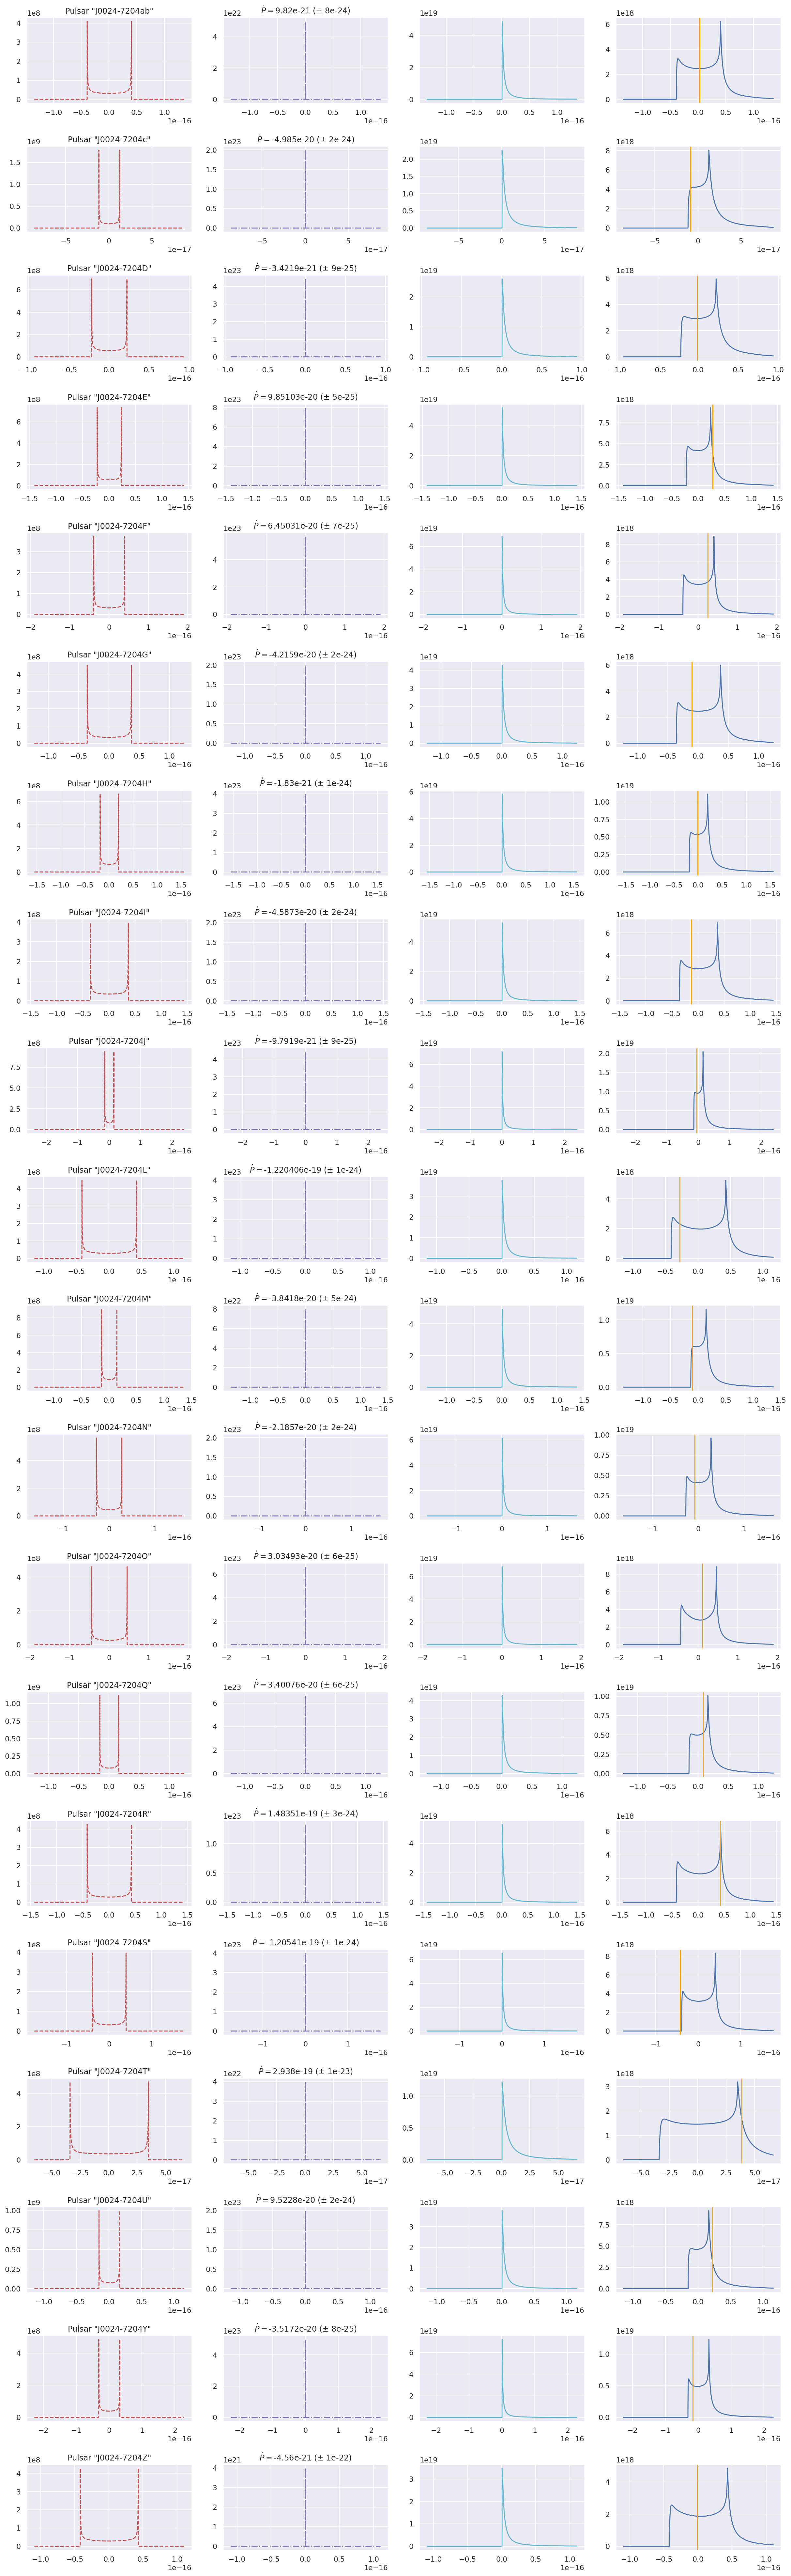

In [8]:
likelihood_pulsar_spin(model, obs['pulsar/spin'], None, μ, crd)

In [9]:
plt.close("all")

In [10]:
obs['pulsar/spin'].__dir__()

['_dict_variables',
 'mdata',
 '_name',
 '__module__',
 '__doc__',
 '__repr__',
 '__str__',
 '__contains__',
 '__getitem__',
 '_init_variables',
 '__init__',
 'variables',
 'build_err',
 '__dict__',
 '__weakref__',
 '__hash__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__new__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [11]:
(obs['pulsar/spin'].variables)

{'P': <Variable [0.00370464, 0.00575678, 0.00535757, 0.00353633, 0.00262358,
            0.00404038, 0.00321034, 0.00348499, 0.00210063, 0.00434617,
            0.00367664, 0.00305395, 0.00264334, 0.00403318, 0.00348046,
            0.00283041, 0.00758848, 0.00434283, 0.00219666, 0.00455445] s>,
 'Pdot_meas': <Variable [ 9.820000e-21, -4.985000e-20, -3.421900e-21,  9.851030e-20,
             6.450310e-20, -4.215900e-20, -1.830000e-21, -4.587300e-20,
            -9.791900e-21, -1.220406e-19, -3.841800e-20, -2.185700e-20,
             3.034930e-20,  3.400760e-20,  1.483510e-19, -1.205410e-19,
             2.938000e-19,  9.522800e-20, -3.517200e-20, -4.560000e-21]>,
 'id': <Variable [b'J0024-7204ab', b'J0024-7204c', b'J0024-7204D', b'J0024-7204E',
            b'J0024-7204F', b'J0024-7204G', b'J0024-7204H', b'J0024-7204I',
            b'J0024-7204J', b'J0024-7204L', b'J0024-7204M', b'J0024-7204N',
            b'J0024-7204O', b'J0024-7204Q', b'J0024-7204R', b'J0024-7204S',
            b'J00

In [12]:
# import pandas as pd

In [13]:
# spin_periods = pd.DataFrame.from_dict(obs['pulsar/spin'].variables)

In [14]:
# spin_periods["sigma_P"] = spin_periods["ΔP"]
# spin_periods["sigma_Pdot"] = spin_periods["ΔPdot_meas"]


In [15]:
# spin_periods.to_csv("47Tuc_spin_periods.dat")